In [1]:
%run nbloader.py
import seaborn
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import pylab as plt
import root_numpy
import pandas as pd
import math
import numpy as np


BRICK_X = 124000
BRICK_Y = 99000
BRICK_Z = 75000
SAFE_M = 10000
dZ = 205

/Users/artem/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/artem/anaconda/envs/py27/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from read_opera_bg import load_bg

importing notebook from read_opera_bg.ipynb
bg: 2767 tracks
len(slopes): 2767


In [3]:
from read_opera_mc import load_mc

importing notebook from read_opera_mc.ipynb
numtracks reduction by cuts:  [188, 186, 109, 50, 19, 19]
len(slopes): 731


In [4]:
pbg = load_bg(step=50)

bg: 546462 tracks


In [5]:
pmc = load_mc(step=1)

numtracks reduction by cuts:  [18724, 18678, 11058, 5389, 2799, 2684]


In [30]:
def plot_bg_and_mc(pbg, pmc, id=0, step=1):
    df = pbg
    # mind the order!
    d0 = pd.DataFrame([
                df['s.eZ'][::step],
                df['s.eX'][::step],
                df['s.eY'][::step]],
                index=['z', 'x', 'y']).T
    numtracks = d0.shape[0]
    dd = pd.DataFrame([
            df['s.eTX'][::step]*dZ,
            df['s.eTY'][::step]*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d1 = d0 + dd
    # print d0, d1
    C = plt.cm.Blues(0.5)
    lc_bg = Line3DCollection(zip(d0.values, d1.values), colors=C, alpha=0.5, lw=2)

    df = pmc.iloc[id]
    # mind the order!
    d0 = pd.DataFrame([
                df['BT_Z'],
                df['BT_X'],
                df['BT_Y']],
                index=['z', 'x', 'y']).T
    numtracks = d0.shape[0]
    dd = pd.DataFrame([
            df['BT_SX']*dZ,
            df['BT_SY']*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d1 = d0 + dd
    C = plt.cm.Reds(0.5)
    lc_mc = Line3DCollection(zip(d0.values, d1.values), colors=C, alpha=0.9, lw=2)
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-84, elev=10)
    ax.add_collection3d(lc_mc)
    ax.add_collection3d(lc_bg)
    
    # mind the order!
    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")
    ax.set_xlim(0, BRICK_Z)
    ax.set_ylim(0, BRICK_X)
    ax.set_zlim(0, BRICK_Y)

In [7]:
plot_bg_and_mc(pbg, pmc, id=1) 

In [6]:
def feature_creator(dmix, pmc, id):
    dZ = 204
    electron = pmc.iloc[id][['ele_x', 'ele_y', 'ele_z', 'ele_sx', 'ele_sy']]
    
    xb_2 = dZ * dmix['b_sx']
    yb_2 = dZ * dmix['b_sy']
    zb_2 = dZ
    
    xe = dZ * electron['ele_sx']
    ye = dZ * electron['ele_sy']
    ze = dZ
    
    dmix['alpha_2'] = (xb_2 * xe + yb_2 * ye + zb_2 * ze)/(((xb_2**2 + yb_2**2 + zb_2**2)**0.5) * ((xe**2 + ye**2 + ze**2)**0.5))
    dmix['alpha_2'] = dmix.apply(lambda x: math.acos(x['alpha_2']), axis=1)
    
    #xp = dmix['b_x']  - zb * dmix['b_sx'] 
    #yp = dmix['b_y']  - zb * dmix['b_sy'] 
    #dmix['IP'] = ((electron['ele_sx'] - xp)**2 + (electron['ele_sy'] - yp)**2)**0.5 / zb
    
    zb = dmix['b_z'] - electron['ele_z']
    xp = dmix['b_x']  + dZ * dmix['b_sx'] 
    yp = dmix['b_y']  + dZ * dmix['b_sy']
    zp = dmix['b_z'] + dZ
    
    el = np.array(electron[0:3], dtype = float)
    IP_0 = np.array([xp, yp, zp], dtype = float)
    IP_1 = np.array([dmix['b_x'], dmix['b_y'], dmix['b_z']], dtype = float)
    length = len(xp)
    IP = []
    
    for i in range(length):
        IP.append(np.linalg.norm(np.cross(el - IP_0[:,i], el - IP_1[:,i]))/np.linalg.norm(IP_0[:,i] - IP_1[:,i]))
    
    dmix['IP'] = IP
    dmix['IP'] = dmix['IP']/zb
     
    
    dmix['d_sx'] = electron['ele_sx'] - dmix['b_sx']
    dmix['d_sy'] = electron['ele_sy'] - dmix['b_sy']
    dmix['zb'] = dmix['b_z'] - electron['ele_z']
                               
    return dmix
                               
                               

In [7]:
def alpha_creator(dmix, pmc, id):
    dZ = 204
    electron = pmc.iloc[id][['ele_x', 'ele_y', 'ele_z', 'ele_sx', 'ele_sy']]
    xb = dmix['b_x'] - electron['ele_x']
    yb = dmix['b_y'] - electron['ele_y']
    zb = dmix['b_z'] - electron['ele_z']
    
    xe = dZ * electron['ele_sx']
    ye = dZ * electron['ele_sy']
    ze = dZ
    
    
    dmix['alpha'] = (xb * xe + yb * ye + zb * ze)/(((xb**2 + yb**2 + zb**2)**0.5) * ((xe**2 + ye**2 + ze**2)**0.5))
    dmix['alpha'] = dmix.apply(lambda x: math.acos(x['alpha']), axis=1)
    
    return dmix

In [8]:
def combine_mc_bg(pmc, pbg, cone_angle = 0.05):
    dZ = 204
    dmix = pd.DataFrame([
                pbg['s.eX'],
                pbg['s.eY'],
                pbg['s.eZ'],
                pbg['s.eTX'],
                pbg['s.eTY']],
                index=['b_x', 'b_y', 'b_z', 'b_sx', 'b_sy']).T
    dmix['signal'] = 0
    final_data = pd.DataFrame().T
    
    a = len(pmc['Event_id'])
    a = 50
    for i in range(a):
        df = pmc.iloc[i]
    
        d0 = pd.DataFrame([
                df['BT_X'],
                df['BT_Y'],
                df['BT_Z'],
                df['BT_SX'],
                df['BT_SY']],
                index=['b_x', 'b_y', 'b_z', 'b_sx', 'b_sy']).T
        d0['signal'] = 1
        
    
        data = pd.concat([dmix, d0]) #pd.concat([dmix[i::a], d0])
        data['event'] = i
        data = alpha_creator(data, pmc, i) # change pmc with electron to save time
        data = data.loc[data['alpha'] < cone_angle]  #save data only inside cone
        if len(data.loc[data['signal'] == 0]['b_x']) != 0: #if there isn't any noise on 
                                                           #the way of shower - delete it
                                                           # make sense?
            data = feature_creator(data, pmc, i) #create fetures only for useful events
            final_data = pd.concat([data, final_data])
        
    
    return final_data

In [9]:
dmix = combine_mc_bg(pmc, pbg, 0.05)

In [10]:
features = list(set(dmix.columns) - {'event', 'signal', 'b_x', 'b_y', 'b_z', 'b_sx', 'b_sy'})

In [38]:
def plot_bg_and_mc_2(pbg, pmc, id=0, step=1):
    df = pbg
    # mind the order!
    d0 = pd.DataFrame([
                df['b_z'][::step],
                df['b_x'][::step],
                df['b_y'][::step]],
                index=['z', 'x', 'y']).T
    numtracks = d0.shape[0]
    dd = pd.DataFrame([
            df['b_sx'][::step]*dZ,
            df['b_sy'][::step]*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d1 = d0 + dd
    # print d0, d1
    C = plt.cm.Blues(0.5)
    lc_bg = Line3DCollection(zip(d0.values, d1.values), colors=C, alpha=0.5, lw=2)

    df=pmc
    # mind the order!
    d0 = pd.DataFrame([
                df['b_z'],
                df['b_x'],
                df['b_y']],
                index=['z', 'x', 'y']).T
    numtracks = d0.shape[0]
    dd = pd.DataFrame([
            df['b_sx']*dZ,
            df['b_sy']*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d1 = d0 + dd
    C = plt.cm.Reds(0.5)
    lc_mc = Line3DCollection(zip(d0.values, d1.values), colors=C, alpha=0.9, lw=2)
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-84, elev=10)
    ax.add_collection3d(lc_mc)
    ax.add_collection3d(lc_bg)
    
    # mind the order!
    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")
    ax.set_xlim(0, BRICK_Z)
    ax.set_ylim(0, BRICK_X)
    ax.set_zlim(0, BRICK_Y)

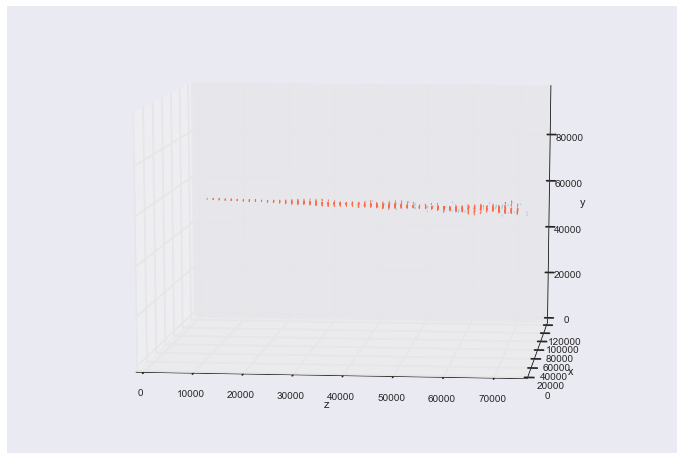

In [41]:
vis_data = dmix.loc[dmix['event'] == 4]
plot_bg_and_mc_2(vis_data.loc[vis_data['signal'] == 0], vis_data.loc[vis_data['signal'] == 1])

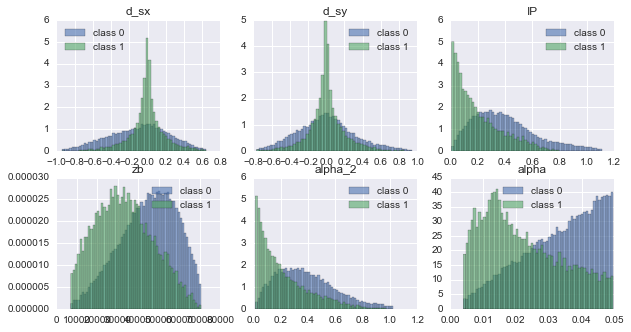

In [55]:
%matplotlib inline
hist_params = {'normed': True, 'bins': 60, 'alpha': 0.6}
# create the figure
plt.figure(figsize=(10, 8))
for n, feature in enumerate(features):
    # add sub plot on our figure
    plt.subplot(len(features) // 2, 3, n+1)
    # define range for histograms by cutting 1% of data from both ends
    min_value, max_value = np.percentile(dmix[feature], [1, 99])
    plt.hist(dmix.ix[dmix.signal.values == 0, feature].values, range=(min_value, max_value), 
             label='class 0', **hist_params)
    plt.hist(dmix.ix[dmix.signal.values == 1, feature].values, range=(min_value, max_value), 
             label='class 1', **hist_params)
    plt.legend(loc='best')
    plt.title(feature)

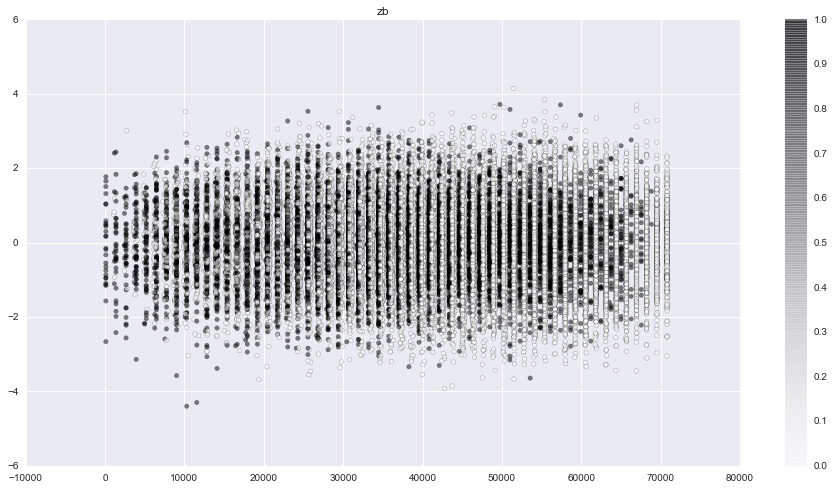

In [48]:
plt.figure(figsize=[16,8])

plt.title("zb")
plt.scatter(dmix.zb, np.random.normal(0,1,len(dmix.zb)) , c= dmix.signal,
            alpha = 0.5)

plt.colorbar()

In [12]:
len(dmix.loc[dmix['signal'] ==0]['b_x'])

42162

In [13]:
#train gbm and rf here
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

training_data, validation_data = train_test_split(dmix, random_state=11, train_size=0.9)
#randomForest = rf(n_estimators=500,max_depth=10)
#randomForest.fit(training_data[features].astype(np.float64), training_data.signal.astype(np.bool))

In [28]:
from sklearn.ensemble import GradientBoostingClassifier as gbm
gradientBoosting = gbm(n_estimators = 200, max_depth = 5)
gradientBoosting.fit(training_data[features].astype(np.float64), training_data.signal.astype(np.bool))

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=5, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [16]:
#from sklearn.svm import SVC
#svm_rbf = SVC(probability = True)
#svm_rbf.fit(training_data[features].astype(np.float64), training_data.signal.astype(np.bool))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [30]:
#rf_proba = randomForest.predict_proba(validation_data[features].astype(np.float64))
gbm_proba = gradientBoosting.predict_proba(validation_data[features].astype(np.float64))
#svm_rbf_proba = svm_rbf.predict_proba(validation_data[features].astype(np.float64))

In [32]:
#print roc_auc_score(validation_data.signal, rf_proba[:,1])
print roc_auc_score(validation_data.signal, gbm_proba[:,1])
#print roc_auc_score(validation_data.signal, svm_rbf_proba[:,1])

0.999826027663


In [33]:
from sklearn.metrics import accuracy_score
print accuracy_score(validation_data.signal, gbm_proba[:,1] > 0.5)

0.99629412912


#### Unfortunately we can't use the distance by z -- coordinate, because this feature takes differnet values for signal and background and gbm can split it with 100% accuracy. What we can do is to add some random noise to that value to make it impossible for model exploit diferent discrete values. 


In [54]:
dmix.zb = dmix.zb + np.random.normal(0,3000,len(dmix.zb))
training_data, validation_data = train_test_split(dmix, random_state=11, train_size=0.9)
gradientBoosting = gbm(n_estimators = 200, max_depth = 5)
gradientBoosting.fit(training_data[features].astype(np.float64), training_data.signal.astype(np.bool))
gbm_proba = gradientBoosting.predict_proba(validation_data[features].astype(np.float64))
print roc_auc_score(validation_data.signal, gbm_proba[:,1])

0.907737389364


## Bingo!
#### Delta Z is still important feature but now classifier can't use the structure of data to predict correct values.

#### IDEA: our observation are dependent as one set of tracks can be a trace of one particle. So we need to use this dependence. As we can't (can't?) recreate the track of particle through brick, we need to use another approach. If classifier gives a high probability to some track to be a signal we can use this track to create features for another tracks?

### What else we need to do:
#### We need to look how value of cone angle affect the classifier qualiity.

In [64]:
for alpha in list([0.06, 0.07, 0.08, 0.09]):
    dmix = combine_mc_bg(pmc, pbg, alpha)
    dmix.zb = dmix.zb + np.random.normal(0,3000,len(dmix.zb))
    training_data, validation_data = train_test_split(dmix, random_state=11, train_size=0.9)
    gradientBoosting = gbm(n_estimators = 200, max_depth = 5)
    gradientBoosting.fit(training_data[features].astype(np.float64), training_data.signal.astype(np.bool))
    gbm_proba = gradientBoosting.predict_proba(validation_data[features].astype(np.float64))
    print str(alpha) + ": " + str(roc_auc_score(validation_data.signal, gbm_proba[:,1]))

0.06: 0.919382042568
0.07: 0.914586435503
0.08: 0.912799779742
0.09: 0.930380396662


### actually we can take a big enough angle to include all the signal in the analysis